# Percentile Distribution Function (PDF) for HRRR and MesoWest

Single Hour

- MesoWest percentile calculations retreived from MesoWest API  
- HRRR percentile calculations generated by the OSG

In [46]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd

In [47]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 6.5
one_column = 3.2
twothird_column = 5.5
mpl.rcParams['figure.figsize'] = [one_column, 2.8]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

### Get lat/lon grid from file to pluck point from HRRR OSG dataset

In [48]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

### Get a point from the OSG percentile grid

In [49]:
def get_point_percentiles(DATE):
    ## PP stands for Percentiles Point
    if DATE.day == 1 and DATE.hour == 0:
        print 'Working on', DATE
    
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
    
    PP = np.array([])
    with h5py.File(DIR+FILE, 'r') as f:
        for i in percentiles:
            PP = np.append(PP, f["p%02d" % i][x][y])
    
    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        PP -= 273.15
    
    return PP

-------

### Input Arguments
statistic can be from the list:  
`mean, p00, p01, p02, p03, p04, p05, p10, p15, p25, p33, p50, p66, p75, p90, p95, p96, p97, p98, p99, p100`

In [50]:
percentiles = [0, 1, 2, 3, 4, 5, 10, 25, 33, 50, 66, 75, 90, 95, 96, 97, 98, 99, 100]
var = 'TMP:2 m'
stn = 'HWKC1'
fxx = 0

# Date of interest
leapyear = 2016
DATE = datetime(leapyear, 10, 9, 6)

##### Additional Setup

In [51]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

if var == 'TMP:2 m':
    MWvar = 'air_temp'
    label = '2 m Temperature (C)'
elif var == 'DPT:2 m':
    MWvar = 'dew_point_temperature'
    label = '2 m Dew Point Temperature (C)'
elif var == 'UVGRD:10 m':
    MWvar = 'wind_speed'
    label = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
elif var == 'UVGRD:80 m':
    MWvar = 'wind_speed'
    label = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
else:
    MWvar = ''
    print "NO MATCHING VAR AND MESOWEST VAR"

## Get HRRR Percentiles
From the OSG files

In [52]:
# Get Time Series Data for each requested Statistic
# HTS is the HRRR-statistic Time Series

# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

pp = get_point_percentiles(DATE)

## Get MesoWest Percentiles
From MesoWest API

In [53]:
start = DATE.strftime('%m%d%H')
end = start

MW_per = get_mesowest_percentiles(stn, variable=MWvar, start=start, end=end, percentiles='ALL', v=True)
print 'MesoWest Station: %s \t Variable: %s' % (stn, MWvar)
print 'Max Years: %s \t Max Count: %s' % (MW_per['years'].max(), MW_per['counts'].max()) 
print 'Min Years: %s \t Min Count: %s' % (MW_per['years'].min(), MW_per['counts'].min())

HR_per = get_mesowest_percentiles(stn, variable=MWvar, psource='PERCENTILES_HRRR')
print '\nHRRR Grid: %s' % stn
print 'Max Count: %s' % (HR_per['counts'].max()) 
print 'Min Count: %s' % (HR_per['counts'].min())

MesoWest API Query:  http://api.synopticlabs.org/v2/percentiles?&token=2562b729557f45f5958516081f06c9eb&start=100906&end=100906&vars=air_temp&stid=HWKC1&psource=PERCENTILES2
MesoWest Station: HWKC1 	 Variable: air_temp
Max Years: 18 	 Max Count: 550
Min Years: 18 	 Min Count: 550

HRRR Grid: HWKC1
Max Count: 90
Min Count: 30


In [54]:
MW_pdf = []
for i in percentiles:
    MW_pdf.append(MW_per['p%02d'%i][0])

## Get value at time

In [55]:
event_datetime = datetime(2017, 10, 9, 6)

# HRRR values
if var.split(':')[0] == 'UVGRD':
    Hu = get_hrrr_variable(event_datetime, 'UGRD:10 m', verbose=False)
    Hv = get_hrrr_variable(event_datetime, 'VGRD:10 m', verbose=False)
    H = Hu.copy()
    H['value'] = wind_uv_to_spd(Hu['value'], Hv['value'])
else:
    H = get_hrrr_variable(event_datetime, var)

HR_event_value = H['value'][x][y]

./temp_2017100906_f00_TMP.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 54:33929691:d=2017100906:TMP:2 m above ground:anl

range: 33929691 35225900


In [56]:
a = get_mesowest_nearesttime(event_datetime, stn, variables=MWvar)

MW_event_value = a[stn][MWvar]['value']

In [57]:
print 'Variable\t:', var
print 'HRRR value    \t: %s\t%s' % (HR_event_value, event_datetime)
print 'Observed value\t: %s\t\t%s' % (MW_event_value, a[stn][MWvar]['DATETIME'])

Variable	: TMP:2 m
HRRR value    	: 292.072	2017-10-09 06:00:00
Observed value	: 18.33		2017-10-09 05:56:00


In [58]:
pp

array([  8.234,   9.345,   9.811,   9.958,  10.044,  10.184,  10.709,
        13.738,  14.306,  16.126,  17.806,  18.931,  20.782,  21.981,
        22.629,  23.686,  24.291,  24.56 ,  26.053])

---
## Plot MesoWest PDF with HRRR PDF

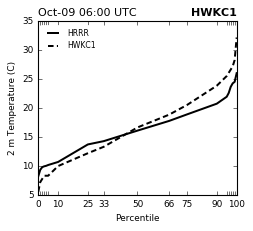

In [59]:
# Plot Percentile Curve
plt.plot(percentiles, pp,
         color='k',
         label='HRRR')
plt.plot(percentiles, MW_pdf,
         color='k',
         linestyle='--', dashes=(5, 3),
         label=stn)

#plt.scatter(100, MW_event_value, s=100)
#plt.scatter(100, HR_event_value, s=100)

#plt.grid()

plt.xlabel('Percentile')
tick_labels = [0,'','','','','', 10, 25, 33, 50, 66, 75, 90, '', '', '', '','',100]
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel('%s' % (label))

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

legend = plt.gca().legend(frameon=True, framealpha=.8, loc=2)
legend.get_frame().set_linewidth(0)
    
plt.title('%s' % DATE.strftime('%b-%d %H:%M UTC'), loc='Left')
plt.title('%s' % (stn), fontweight='bold', loc='right')
plt.savefig('./figs/PDF_%s_%s_%s' % (stn.upper(), variable, DATE.strftime('m%m_d%d_h%H')))